In [1]:
from numpy import *
from numpy.random import *
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.basemap import Basemap
from PlotFuncs import *
from LabFuncs import *
from Params import *
from HaloFuncs import *
from scipy.stats import norm
import pandas

# Load shards
df = pandas.read_csv('../data/FitShards.csv')
names = df.group_id
nshards = size(names)
velocities = zeros(shape=(nshards,3))
dispersions = zeros(shape=(nshards,3))
velocities[0:(nshards),0] = df.vx # stream velocities
velocities[0:(nshards),1] = df.vy
velocities[0:(nshards),2] = df.vz
dispersions[0:(nshards),0] = df.sigx # dispersion tensors
dispersions[0:(nshards),1] = df.sigy
dispersions[0:(nshards),2] = df.sigz
pops = df.population
Psun = df.Psun
Psun[Psun==inf] = 0.0
pops[1] = 30.0
weights = pops#*norm.pdf(Psun,loc=0.0,scale=1.0)/norm.pdf(0.0,loc=0.0,scale=1.0)
weights /= sum(weights)



/Users/ciaranohare/anaconda/lib/python2.7/site-packages/cryptography/hazmat/primitives/constant_time.py:26: CryptographyDeprecationWarning: Support for your Python version is deprecated. The next version of cryptography will remove support. Please upgrade to a 2.7.x release that supports hmac.compare_digest as soon as possible.
  utils.DeprecatedIn23,


/Users/ciaranohare/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/ciaranohare/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [109]:
# Figure setup
from mpl_toolkits.basemap import shiftgrid


# Set up binning
n = 400
ph = flipud(linspace(-pi, pi-2*pi/n, n))
th = linspace(0,pi, n/2)
PH,TH = meshgrid(ph,th)
X = cos(PH)*sin(TH)
Y = -sin(PH)*sin(TH)
Z = cos(TH)
ii = 0
q = zeros(shape=(n*n/2,3))
for i in range(0,n/2):
    for j in range(0,n):
        q[ii,:] = array([X[i,j],Y[i,j],Z[i,j]])
        ii = ii+1
        
def convertmap(fv3D):
    fv_map = zeros(shape=(n/2,n))
    ii = 0
    for i in range(0,n/2):
        for j in range(0,n):
            fv_map[i,j] = fv3D[ii]
            ii = ii+1
    fv_map = flipud(fv_map)
    return fv_map



# v binning
nv = 1000
v_vals = linspace(0.1,600,nv)

# Halo params
HaloModel = SHMpp
v0 = HaloModel.RotationSpeed
v_esc = HaloModel.EscapeSpeed
sig_beta = HaloModel.SausageDispersionTensor
sig_iso = array([1.0,1.0,1.0])*v0/sqrt(2.0)
day = 67.0 

# Smooth
fv3D_Saus = zeros(shape=n*n/2)
fv3D_Iso = zeros(shape=n*n/2)
for j in range(0,nv):
    fv3D_Iso += v_vals[j]*VelocityDist_Triaxial(-v_vals[j]*q,day,sig_iso)
    fv3D_Saus += v_vals[j]*VelocityDist_Triaxial(-v_vals[j]*q,day,sig_beta)
fv_map_Saus = convertmap(fv3D_Saus)
fv_map_Iso = convertmap(fv3D_Iso)
    
# Shards
fv_map_shards = zeros(shape=(n/2,n,nshards))
for isub in range(0,nshards):
    v_str = velocities[isub,:]
    x_str = v_str/sqrt(sum(v_str**2.0))
    sig_s = dispersions[isub,:]
    fv3D = zeros(shape=(n*n/2))
    for j in range(0,nv):
        fv3D += v_vals[j]*weights[isub]*VelocityDist_Triaxial(-v_vals[j]*q,day,sig_s,v_shift=v_str)
    print isub
    fv_map_shards[:,:,isub] = convertmap(fv3D)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68


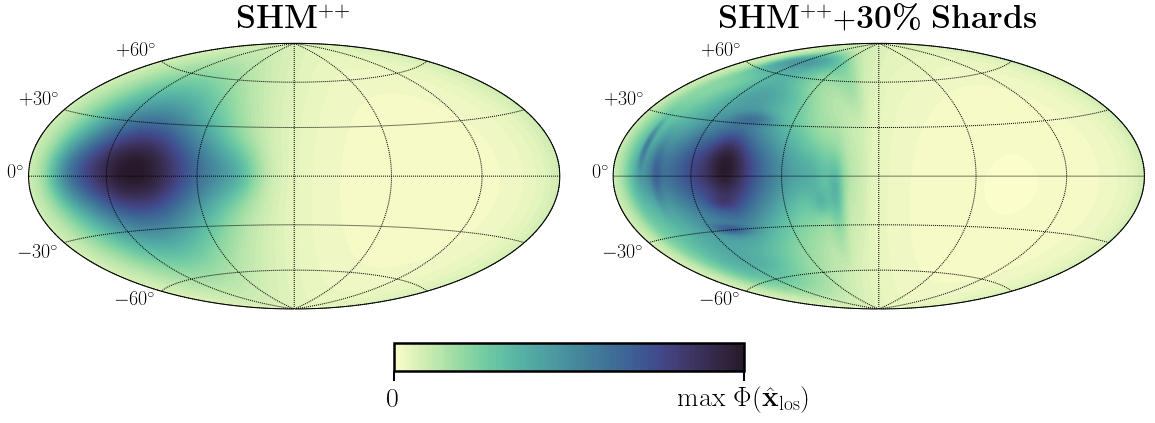

In [140]:
from IPython.display import clear_output
import matplotlib.gridspec as gridspec


plt.rcParams['axes.linewidth'] = 2.5
    
    
fig, axarr = plt.subplots(1, 2,figsize=(20,10))
gs = gridspec.GridSpec(1, 2)
gs.update(wspace=0.1)
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

import cmocean
cmap = cmocean.cm.deep

eta = 0.2
xi = 0.3
fv0 = (1-eta)*fv_map_Iso + eta*fv_map_Saus
fv_tot = (1-xi)*fv0 + xi*sum(fv_map_shards,2)

vmax = amax(fv_tot)


plt.sca(ax1)
m = Basemap(projection='hammer',lon_0=180.0,resolution='c',celestial=True)
m.contourf(PH*180/pi, TH*180/pi-90.0,fv0,100,cmap=cmap,latlon=True,vmin=0.0,vmax=vmax)
m.contourf(PH*180/pi, TH*180/pi-90.0,fv0,100,cmap=cmap,latlon=True,vmin=0.0,vmax=vmax)
m.contourf(PH*180/pi, TH*180/pi-90.0,fv0,100,cmap=cmap,latlon=True,vmin=0.0,vmax=vmax)

clear_output()

m.drawparallels(arange(-90.,120.,30.),labels=[1,0,0,0],color='k',fontsize=20) # draw parallels
m.drawmeridians(arange(0.,420.,60.),color='k',fontsize=20) # draw meridians
plt.title(r'{\bf SHM}$^{++}$',fontsize=32,y=1.03)

plt.sca(ax2)
m = Basemap(projection='hammer',lon_0=180.0,resolution='c',celestial=True)
m.contourf(PH*180/pi, TH*180/pi-90.0,fv_tot,100,cmap=cmap,latlon=True,vmin=0.0,vmax=vmax)
m.contourf(PH*180/pi, TH*180/pi-90.0,fv_tot,100,cmap=cmap,latlon=True,vmin=0.0,vmax=vmax)
m.contourf(PH*180/pi, TH*180/pi-90.0,fv_tot,100,cmap=cmap,latlon=True,vmin=0.0,vmax=vmax)

clear_output()

col_ex = (cm.Reds(linspace(0,1,5)))

# levels = [0.9,1.0]
# # S1
# isub = 0
# m.contour(PH*180/pi, TH*180/pi-90.0,fv_map_shards[:,:,isub]/amax(fv_map_shards[:,:,isub]),colors=(col_ex[0,:],),levels=levels,linestyles='--',latlon=True,label='S1')
# clear_output()

# # S2
# isub = 1
# m.contour(PH*180/pi, TH*180/pi-90.0,fv_map_shards[:,:,isub]/amax(fv_map_shards[:,:,isub]),colors=(col_ex[0,:],),levels=levels,linestyles='--',latlon=True,label='S2')
# clear_output()

# isub = 2
# m.contour(PH*180/pi, TH*180/pi-90.0,fv_map_shards[:,:,isub]/amax(fv_map_shards[:,:,isub]),colors=(col_ex[0,:],),levels=levels,linestyles='--',latlon=True)
# clear_output()

# # # Rg1
# isub = 4
# m.contour(PH*180/pi, TH*180/pi-90.0,fv_map_shards[:,:,isub]/amax(fv_map_shards[:,:,isub]),colors=(col_ex[0,:],),levels=levels,linestyles='--',latlon=True)
# clear_output()

# # # Rg3
# isub = 6
# m.contour(PH*180/pi, TH*180/pi-90.0,fv_map_shards[:,:,isub]/amax(fv_map_shards[:,:,isub]),colors=(col_ex[0,:],),levels=levels,linestyles='--',latlon=True)
# clear_output()
# isub = 7
# m.contour(PH*180/pi, TH*180/pi-90.0,fv_map_shards[:,:,isub]/amax(fv_map_shards[:,:,isub]),colors=(col_ex[0,:],),levels=levels,linestyles='--',latlon=True)
# clear_output()

# # # Cand14
# isub = 20
# m.contour(PH*180/pi, TH*180/pi-90.0,fv_map_shards[:,:,isub]/amax(fv_map_shards[:,:,isub]),colors=(col_ex[0,:],),levels=levels,linestyles='--',latlon=True)
# clear_output()
# isub = 21
# m.contour(PH*180/pi, TH*180/pi-90.0,fv_map_shards[:,:,isub]/amax(fv_map_shards[:,:,isub]),colors=(col_ex[0,:],),levels=levels,linestyles='--',latlon=True)
# clear_output()

m.drawparallels(arange(-90.,120.,30.),labels=[1,0,0,0],color='k',fontsize=20) # draw parallels
m.drawmeridians(arange(0.,420.,60.),color='k',fontsize=20) # draw meridians
plt.title(r'{\bf SHM}$^{++}$+{\bf 30\%} {\bf Shards}',fontsize=32,y=1.03)


# # Custom colorbar
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
cbaxes = inset_axes(ax1, width="50%", height="7%", bbox_to_anchor=[200, -200, 700, 400]) 
norm = mpl.colors.Normalize(vmin=0,vmax=1)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm,cax=cbaxes,ticks=(0,1),boundaries=linspace(0,1,100),orientation='horizontal')
f = plt.gcf().get_children()
cbar = f[3]
cbar.set_xticklabels(['0', r'max $\Phi(\hat{\mathbf{x}}_{\rm los})$'])  # vertically oriented colorbar
cbar.tick_params(labelsize=28) 
cbar.tick_params(which='major',direction='out',width=2,length=10,right=True,top=False,pad=7)
cbar.tick_params(which='minor',direction='out',width=2,length=7,right=True,top=False)



plt.show()
pltname = 'ShardsFlux'
fig.savefig('../plots/'+pltname+'.pdf',bbox_inches='tight')
fig.savefig('../plots/plots_png/'+pltname+'.png',bbox_inches='tight')

In [248]:
from WIMPFuncs import *

n = 200
ph = linspace(-pi, pi-2*pi/n, n)
th = linspace(0,pi, n/2)
PH,TH = meshgrid(ph,th)
X = cos(PH)*sin(TH)
Y = -sin(PH)*sin(TH)
Z = cos(TH)
ii = 0
q = zeros(shape=(n*n/2,3))
for i in range(0,n/2):
    for j in range(0,n):
        q[ii,:] = array([X[i,j],Y[i,j],Z[i,j]])
        ii = ii+1

# Benchmark
ne = 100
nbins = 3
E = zeros(shape=(nbins,ne))
E[0,:] = linspace(1.0,5.0,ne)
E[1,:] = linspace(5.0,10.0,ne)
E[2,:] = linspace(10.0,20.0,ne)

m_chi = 20.0
sigma_p = 1.0e-45
A = F19.MassNumber
eta = 0.2

# Radon transform and rate
dR_smooth = zeros(shape=(3,n*n/2))
dR_shards = zeros(shape=(3,n*n/2))
fhat0 = zeros(shape=(n*n/2))
for ibin in range(0,nbins):
    E_r = E[ibin,:]
    v_min = MinimumWIMPSpeed(E_r,A,m_chi)
    for ie in range(0,ne):
        fhat0 = fhat_Isotropic(v_min[ie],-1.0*q,day)
        dR_smooth[ibin,:] += (1-eta)*diffRecoilRate_SI(E_r[ie],fhat0,A,sigma_p,m_chi)
        fhat_saus = fhat_Triaxial(v_min[ie],-1.0*q,day,sig_beta)
        dR_smooth[ibin,:] += eta*diffRecoilRate_SI(E_r[ie],fhat_saus,A,sigma_p,m_chi)
        
        fhat = zeros(shape=(n*n/2))
        for i in range(0,nshards):
            v_s = velocities[i,:]
            sig_s = dispersions[i,:]
            fhat += weights[i]*fhat_Triaxial(v_min[ie],-1.0*q,day,sig_s,v_shift=v_s)
        dR_shards[ibin,:] += diffRecoilRate_SI(E_r[ie],fhat,A,sigma_p,m_chi)
    print 'bin =',ibin

    

# Convert list into Mollweide map
dR_map_smooth = zeros(shape=(n/2,n,3))
dR_map_shards = zeros(shape=(n/2,n,3))
for ibin in range(0,3):
    ii = 0
    for i in range(0,n/2):
        for j in range(0,n):
            dR_map_smooth[i,j,ibin] = dR_smooth[ibin,ii]
            dR_map_shards[i,j,ibin] = dR_shards[ibin,ii]
            ii = ii+1
    dR_map_smooth[:,:,ibin] = flipud(dR_map_smooth[:,:,ibin])     
    dR_map_shards[:,:,ibin] = flipud(dR_map_shards[:,:,ibin])  
    

bin = 0
bin = 1
bin = 2


In [249]:
qq = zeros(shape=(n/2,n,3))
ii = 0
for i in range(0,n/2):
    for j in range(0,n):
        qq[i,j,0] = q[ii,0]
        qq[i,j,1] = q[ii,1]
        qq[i,j,2] = q[ii,2]
        ii = ii+1

# Apply angular res.
sig_a = 10*pi/180.0
def angres(q0):
    gamma = q0[0]*qq[:,:,0]+q0[1]*qq[:,:,1]+q0[2]*qq[:,:,2]
    gamma[gamma>1] = 1.0
    gamma[gamma<-1] = -1.0
    gamma = arccos(gamma)
    return exp(-gamma**2.0/(2*sig_a**2.0))

def applyangres(dR_map):
    dR_map_s = zeros(shape=(n/2,n,3))
    for ibin in range(0,3):
        for i in range(0,n/2):
            for j in range(0,n):
                K = angres(squeeze(qq[i,j,:]))
                Knorm = trapz(flipud(trapz(K,ph,axis=1)),flipud(cos(th)))
                dR_map_s[i,j,ibin] = trapz(flipud(trapz(K*dR_map[:,:,ibin],ph,axis=1)),flipud(cos(th)))/Knorm
    return dR_map_s
                
dR_map_smooth_s = applyangres(dR_map_smooth)
dR_map_shards_s = applyangres(dR_map_shards)

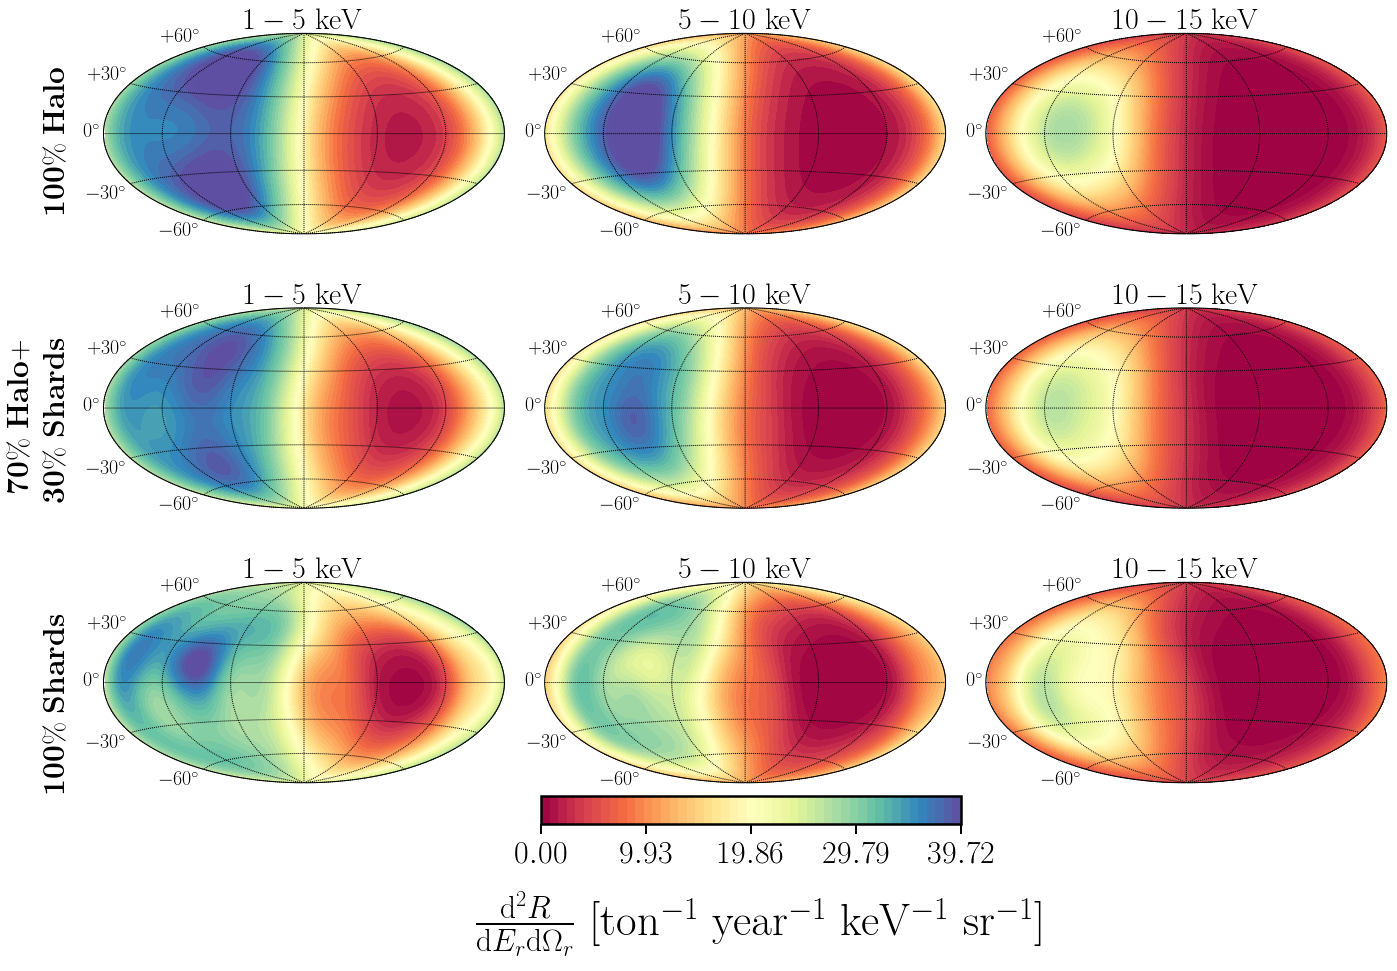

In [253]:
fig, axarr = plt.subplots(3, 3,figsize=(23,15))
gs = gridspec.GridSpec(3, 3)
gs.update(wspace=0.1,hspace=0.03)


cmap = cm.Spectral


tit = [r'$1 - 5$ keV',r'$5-10$ keV',r'$10-15$ keV']

xi = 0.3
dR2 = (1-xi)*dR_map_smooth_s+xi*dR_map_shards_s

vmin = amin(dR2)
vmax = amax(dR2)

ncons = 50

for ibin in range(0,3): 
    plt.sca(plt.subplot(gs[0,ibin]))
    m = Basemap(projection='hammer',lon_0=180.0,resolution='c',celestial=True)
    #for i in range(0,4): # loop is to cure some rendering issues with matplotlib
    m.contourf(PH*180/pi, TH*180/pi-90.0, dR_map_smooth_s[:,:,ibin],ncons, cmap=cmap,latlon=True,vmin=vmin,vmax=vmax)
    m.contourf(PH*180/pi, TH*180/pi-90.0, dR_map_smooth_s[:,:,ibin],ncons, cmap=cmap,latlon=True,vmin=vmin,vmax=vmax)
    m.contourf(PH*180/pi, TH*180/pi-90.0, dR_map_smooth_s[:,:,ibin],ncons, cmap=cmap,latlon=True,vmin=vmin,vmax=vmax)
    m.drawparallels(arange(-90.,120.,30.),labels=[1,0,0,0],color='k',fontsize=20) # draw parallels
    m.drawmeridians(arange(0.,420.,60.),color='k',fontsize=20) # draw meridians
    plt.title(tit[ibin],fontsize=30)
    clear_output()


for ibin in range(0,3): 
    plt.sca(plt.subplot(gs[1,ibin]))
    m = Basemap(projection='hammer',lon_0=180.0,resolution='c',celestial=True)
    #for i in range(0,4): # loop is to cure some rendering issues with matplotlib
    m.contourf(PH*180/pi, TH*180/pi-90.0,dR2[:,:,ibin],ncons, cmap=cmap,latlon=True,vmin=vmin,vmax=vmax)
    m.contourf(PH*180/pi, TH*180/pi-90.0,dR2[:,:,ibin],ncons, cmap=cmap,latlon=True,vmin=vmin,vmax=vmax)
    m.contourf(PH*180/pi, TH*180/pi-90.0,dR2[:,:,ibin],ncons, cmap=cmap,latlon=True,vmin=vmin,vmax=vmax)
    m.drawparallels(arange(-90.,120.,30.),labels=[1,0,0,0],color='k',fontsize=20) # draw parallels
    m.drawmeridians(arange(0.,420.,60.),color='k',fontsize=20) # draw meridians
    plt.title(tit[ibin],fontsize=30)
    clear_output()

dR3 = dR_map
for ibin in range(0,3): 
    plt.sca(plt.subplot(gs[2,ibin]))
    m = Basemap(projection='hammer',lon_0=180.0,resolution='c',celestial=True)
    m.contourf(PH*180/pi, TH*180/pi-90.0, dR_map_shards_s[:,:,ibin],ncons, cmap=cmap,latlon=True,vmin=vmin,vmax=vmax)
    m.contourf(PH*180/pi, TH*180/pi-90.0, dR_map_shards_s[:,:,ibin],ncons, cmap=cmap,latlon=True,vmin=vmin,vmax=vmax)
    m.contourf(PH*180/pi, TH*180/pi-90.0, dR_map_shards_s[:,:,ibin],ncons, cmap=cmap,latlon=True,vmin=vmin,vmax=vmax)
    m.drawparallels(arange(-90.,120.,30.),labels=[1,0,0,0],color='k',fontsize=20) # draw parallels
    m.drawmeridians(arange(0.,420.,60.),color='k',fontsize=20) # draw meridians
    plt.title(tit[ibin],fontsize=30)
    clear_output()

    
    
plt.sca(plt.subplot(gs[0,0]))
plt.annotate(r'{\bf 100}\% {\bf Halo}', xy=(-0.15, 0.75), xycoords='axes fraction',fontsize=30,rotation=90)

plt.sca(plt.subplot(gs[1,0]))
plt.annotate(r'{\bf 70}\% {\bf Halo}+', xy=(-0.24, 0.75), xycoords='axes fraction',fontsize=30,rotation=90)
plt.annotate(r'{\bf 30}\% {\bf Shards}', xy=(-0.15, 0.75), xycoords='axes fraction',fontsize=30,rotation=90)

plt.sca(plt.subplot(gs[2,0]))
plt.annotate(r'{\bf 100}\% {\bf Shards}', xy=(-0.15, 0.75), xycoords='axes fraction',fontsize=30,rotation=90)



# # Custom colorbar
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
cbaxes = inset_axes(plt.subplot(gs[2,1]), width="60%", height="7%", bbox_to_anchor=[370, -240, 700, 400]) 
norm = mpl.colors.Normalize(vmin=vmin,vmax=vmax)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm,cax=cbaxes,ticks=linspace(vmin,vmax,5),boundaries=linspace(vmin,vmax,ncons),orientation='horizontal')
f = plt.gcf().get_children()
cbar = f[3]
plt.tick_params(which='major',direction='out',width=2,length=10,right=True,top=False,pad=7,labelsize=32)
plt.tick_params(which='minor',direction='out',width=2,length=7,right=True,top=False,labelsize=32)
plt.gcf().text(0.35,-0.004,r'$\frac{\mathrm{d}^2 R}{\mathrm{d}E_r \mathrm{d}\Omega_r}$ [ton$^{-1}$ year$^{-1}$ keV$^{-1}$ sr$^{-1}$]',fontsize=45)
# save figure
plt.show()
fig.savefig('../plots/'+pltname+'.pdf',bbox_inches='tight')
fig.savefig('../plots/plots_png/'+pltname+'.png',bbox_inches='tight')

In [237]:
amax(dR_map0_s)

33.403162229535404

In [224]:
vmax

nan